### This example implements the Vision Transformer (ViT) model by Alexey Dosovitskiy et al. for image classification, and demonstrates it on the Pneumonia detection dataset.

While the Transformer architecture has become the de-facto standard for natural
language processing tasks, its applications to computer vision remain limited. In
vision, attention is either applied in conjunction with convolutional networks, or
used to replace certain components of convolutional networks while keeping their
overall structure in place. We show that this reliance on CNNs is not necessary
and a pure transformer applied directly to sequences of image patches can perform well on image classification tasks.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator, load_img
import matplotlib.pyplot as plt
import cv2
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from tensorflow.keras import datasets, layers, models
from keras.preprocessing.image import load_img, img_to_array
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import random
import warnings
warnings.filterwarnings('ignore')
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
tf.version.VERSION

'2.4.1'

In [3]:
#Set the train and test folders
train_folder = '/Users/nikhilshakkarwar/Documents/Nikhil/Education/MScA/Spring 2021/Machine Learning/Project/chest_xray/train'
val_folder = '/Users/nikhilshakkarwar/Documents/Nikhil/Education/MScA/Spring 2021/Machine Learning/Project/chest_xray/val'
test_folder = '/Users/nikhilshakkarwar/Documents/Nikhil/Education/MScA/Spring 2021/Machine Learning/Project/chest_xray/test'

In [4]:
num_classes = 1
input_shape = (128, 128, 3)


In [5]:
dsize =(128, 128)

labels = {"NORMAL":0, "PNEUMONIA":1}

In [6]:
def load_images(dir_path, labels, dsize = dsize):
    """loading images"""
    X_image, y_image = [], []
    for label_name, Id in labels.items():
        for jpeg in tqdm(os.listdir(os.path.join(dir_path, label_name))):
            path = os.path.join(dir_path, label_name, jpeg)
            image = load_img(path, target_size=dsize)
            X_image.append(image)
            y_image.append(Id)
    return X_image, y_image


In [7]:
X_train_org, y_train = load_images(train_folder, labels, dsize = dsize)

100%|██████████| 3875/3875 [00:25<00:00, 150.61it/s]


In [8]:
X_test_org, y_test = load_images(test_folder, labels, dsize = dsize)

100%|██████████| 390/390 [00:02<00:00, 178.48it/s]


In [9]:
X_val_org, y_val = load_images(val_folder, labels, dsize = dsize)

100%|██████████| 8/8 [00:00<00:00, 148.94it/s]


Let's display patches for a sample image

In [10]:
def display_images(X, y, figure_row=4, figure_cols=4):
    """Display images """
    f, ax = plt.subplots(nrows= figure_row, ncols=figure_cols, 
                         figsize=(figure_row*figure_cols, figure_row*figure_cols)) 
    number_of_images = figure_row * figure_cols
    img = []
    for i in range(figure_row):
        for j in range(figure_cols):
            while True:
                rand = np.random.randint(0, len(X)-1)
                if rand not in img:
                    img.append(rand)
                    break
            image=X[rand]#cv2.imread(self.path_lsts[rand])
            ax[i, j].imshow(image, resample=True, cmap='RdYlBu')
            ax[i, j].set_title("Class-"+ str(y[rand]), fontsize=16)
    plt.tight_layout()
    plt.show()
    print

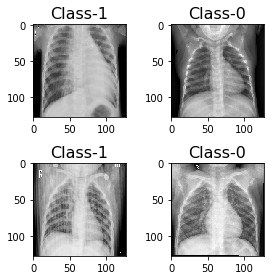

In [11]:
display_images(X_train_org, y_train, figure_row=2, figure_cols=2)

In [12]:
def preprocess_images(images, y, normalize = True):
    X = []
    for i in tqdm(range(len(images))):
        img = img_to_array(images[i]).astype('float32')
        if normalize:
            img = img/255.0
        X.append(img)
    #Shuffle data
    dataset = list(zip(X, y))   # try removing this later
    random.shuffle(dataset)     # try removing this later

    X, y = zip(*dataset)        # try removing this later
    return np.array(X), np.array(y)

In [13]:
normalize = True

X_train, y_train =preprocess_images(X_train_org, y_train, normalize=normalize)
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

X_val, y_val =preprocess_images(X_val_org, y_val, normalize=normalize)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)

X_test, y_test =preprocess_images(X_test_org, y_test, normalize=normalize)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

 27%|██▋       | 167/624 [00:00<00:00, 1657.65it/s]

Shape of X_train: (5216, 128, 128, 3)
Shape of y_train: (5216,)
Shape of X_val: (16, 128, 128, 3)
Shape of y_val: (16,)


100%|██████████| 624/624 [00:00<00:00, 2136.60it/s]


Shape of X_test: (624, 128, 128, 3)
Shape of y_test: (624,)


In [14]:
y_train = y_train.reshape(5216, 1)

In [15]:
y_val = y_val.reshape(16, 1)

In [16]:
y_test = y_test.reshape(624, 1)

In [17]:
print("Shape of y_train:", y_train.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of y_test:", y_test.shape)

Shape of y_train: (5216, 1)
Shape of y_val: (16, 1)
Shape of y_test: (624, 1)


### Configure the hyperparameters

In [18]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 10
image_size = 128  # We'll resize input images to this size
patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


### Use data augmentation

In [19]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.Resizing(image_size, image_size),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)


### Implement multilayer perceptron (MLP)

In [20]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.relu)(x)  # try implementing relu
        x = layers.Dropout(dropout_rate)(x)
    return x


### Implement patch creation as a layer

In [21]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="SAME",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


Image size: 128 X 128
Patch size: 16 X 16
Patches per image: 64
Elements per patch: 768


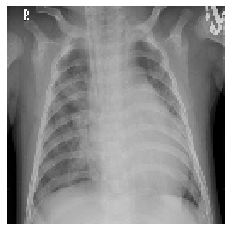

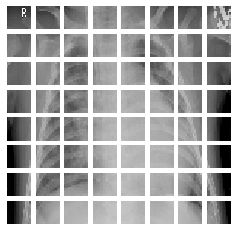

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image)
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy())
    plt.axis("off")

### Implement the patch encoding layer

In [23]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


### Build the ViT model

In [24]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes, activation='softmax')(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


### Compile, train, and evaluate the mode

In [25]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[
                'accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')
        ],
    )
    
    checkpoint_path = '/Users/nikhilshakkarwar/Documents/Nikhil/Education/MScA/Spring 2021/Machine Learning/Project'
    checkpoint_dir = os.path.dirname(checkpoint_path)
    ckpt = ModelCheckpoint(
    filepath = checkpoint_dir,
    save_best_only = True)

    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
    )

    loss, acc, prec, rec = model.evaluate(X_test, y_test)
    print(f"Test loss: {loss}")
    print(f"Test accuracy: {round(acc * 100, 2)}%")
    print(f"Test precision: {round(prec * 100, 2)}%")
    print(f"Test recall: {round(rec * 100, 2)}%")
    
    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


Epoch 1/10
147/147 [==============================] - 66s 400ms/step - loss: 1.0276 - accuracy: 0.7504 - precision: 0.7504 - recall: 1.0000 - val_loss: 0.2472 - val_accuracy: 0.7241 - val_precision: 0.7241 - val_recall: 1.0000
Epoch 2/10
147/147 [==============================] - 56s 381ms/step - loss: 0.3025 - accuracy: 0.7424 - precision: 0.7424 - recall: 1.0000 - val_loss: 0.2206 - val_accuracy: 0.7241 - val_precision: 0.7241 - val_recall: 1.0000
Epoch 3/10
147/147 [==============================] - 55s 376ms/step - loss: 0.2922 - accuracy: 0.7408 - precision: 0.7408 - recall: 1.0000 - val_loss: 0.1913 - val_accuracy: 0.7241 - val_precision: 0.7241 - val_recall: 1.0000
Epoch 4/10
147/147 [==============================] - 55s 377ms/step - loss: 0.2728 - accuracy: 0.7489 - precision: 0.7489 - recall: 1.0000 - val_loss: 0.1791 - val_accuracy: 0.7241 - val_precision: 0.7241 - val_recall: 1.0000
Epoch 5/10
147/147 [==============================] - 55s 376ms/step - loss: 0.2392 - accura

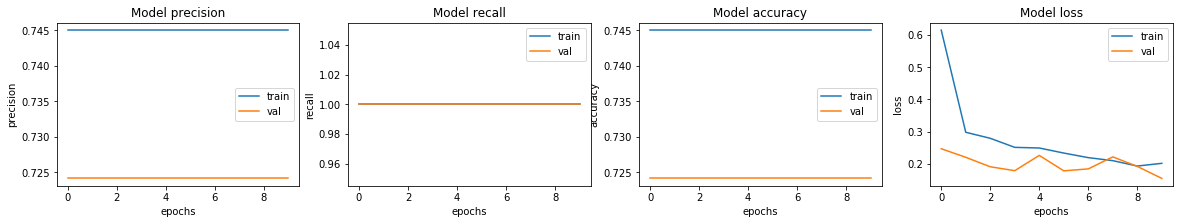

In [26]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])